### The Laplace Equation

We want to solve the Laplace Equation using the finite element variational method, that is easily implemented by the libraries included in the FEniCSx Project.

The problem to solve is the following:

\begin{equation*}
    \begin{cases}
        \frac{\partial ^ 2 u(x, y)}{\partial x ^ 2} + \frac{\partial ^ 2 u(x, y)}{\partial y ^ 2} = 0 \quad \text{for} \quad (x, y) \in \Omega \\
        u(x, y) = f(x, y) \quad \text{for} \quad (x, y) \in \partial \Omega
    \end{cases}
\end{equation*}

Where $u(x, y)$ is the unknown function, $f(x, y)$ is a prescribed function and $\Omega$ is the two-dimensional domain. We can rewrite easily the partial differential equation by using laplacian operator:

\begin{equation*}
    \nabla ^ 2 u(x, y) = 0
\end{equation*}

Let $v(x, y)$ be a test function. By multiplying the equation by $v(x, y)$ and integrating over the domain $\Omega$, we obtain:

\begin{equation*}
    \int _ \Omega [ \nabla ^ 2 u(x, y)] v \, dx = 0
\end{equation*}

By integrating by parts the first term of the equation and assuming that $v(x,y)$ is null on the whole boundary $\partial \Omega$, we obtain:

\begin{equation*}
    \int _ \Omega \nabla u(x, y) \cdot \nabla v(x, y) \, dx = 0
\end{equation*}

By defining the first member of the equation as $\alpha (u, v)$, we obtain the weak form or variational form of the Laplace Equation:

\begin{equation*}
    \alpha (u, v) = 0
\end{equation*}

Let's solve the problem in the unit square domain $\Omega = [0, 1] \times [0, 1]$ with the prescribed function $f(x, y) = 1 + x ^2 + y ^ 2$

In [1]:
from mpi4py import MPI # MPI (Massage Passing Interface) for parallel programming
from dolfinx import mesh # dolfinx from the FEniCSx Project, for solving partial differential equations
from dolfinx import plot # Plotting tool with PyVista stuff
from dolfinx.fem import functionspace # Importing functionspace for creating the finite element function space
from dolfinx.fem import Function # Importing the Function class, for creating objects into the finite element function space
from dolfinx.fem import locate_dofs_topological # Importing this to locate the degrees of freedom on the boundary facets
from dolfinx.fem import dirichletbc # Importing this to implement the Dirichlet boundary conditions
from dolfinx.fem import Constant # For defining costant functions in dolfinx
from dolfinx import default_scalar_type # For defining scalar values in dolfinx
from ufl import TrialFunction, TestFunction, dot, grad, dx # Unified Form Language to describe variational forms
from dolfinx.fem.petsc import LinearProblem # Class for solving variational problems using LU-factorization 
import pyvista as pv # Importing PyVista

In [2]:
Omega = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral) # Defining the domain Omega as a unit square divided into 64 quadrilaterals

In [3]:
V = functionspace(Omega, ("Lagrange", 1)) # Defining the function space made up of linear Lagrange polynomials

In [4]:
f = Function(V) # Defining the prescribed function as an instance of the class Function
f.interpolate(lambda x: 1 + x[0] ** 2 + 2 * x[1] ** 2) # Defining the mathematical expression of f

In [5]:
topology_dimension = Omega.topology.dim # Determining the topological dimension of the mesh Omega
facet_dimension = topology_dimension - 1 # Calculating the facet dimension
Omega.topology.create_connectivity(facet_dimension, topology_dimension) # Creating connectivity
boundary_facets = mesh.exterior_facet_indices(Omega.topology) # Retrieving the indices

In [6]:
boundary_degrees_of_freedom = locate_dofs_topological(V, facet_dimension, boundary_facets) # Calculating DOF
boundary_conditions = dirichletbc(f, boundary_degrees_of_freedom) # Assuming Dirichlet boundary conditions

In [7]:
u = TrialFunction(V) # Defining the trial function
v = TestFunction(V) # Defining the test function
source_term = Constant(Omega, default_scalar_type(0.0)) # Defining the source term

In [8]:
alpha = dot(grad(u), grad(v)) * dx # First member of the variational equation
L = source_term * v * dx # Second member of the variational equation (zero)

In [9]:
problem = LinearProblem(alpha, L, bcs = [boundary_conditions], petsc_options = {"ksp_type": "preonly", "pc_type": "lu"}) # Creating the linear problem object
solution = problem.solve() # Solving it thereby getting the solution

Plotting time!


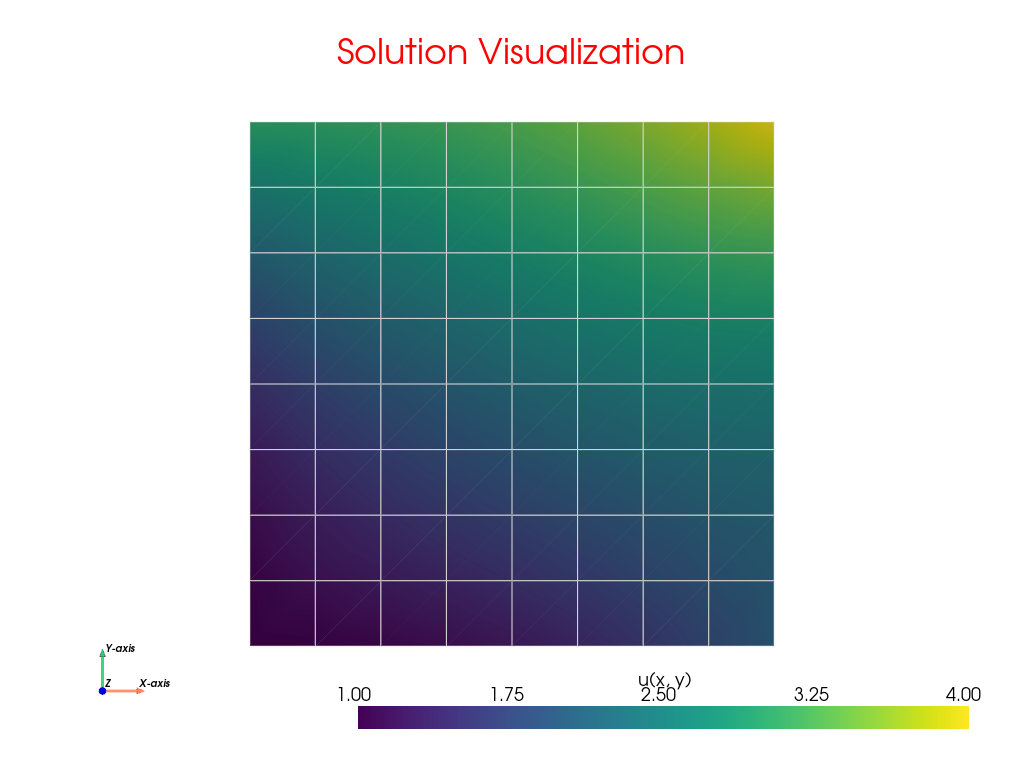

In [10]:
topology, cell_types, geometry = plot.vtk_mesh(Omega, topology_dimension) # Converting objects into Pyvista assets
grid = pv.UnstructuredGrid(topology, cell_types, geometry) # PyVista UnstructuredGrid instance
plotter = pv.Plotter() # PyVista Plotter instance
plotter.add_mesh(grid, show_edges = True) # Adding the mesh grid
plotter.view_xy() # 2D grid
sol_topology, sol_cell_types, sol_geometry = plot.vtk_mesh(V) # Preparing the solution graph
sol_grid = pv.UnstructuredGrid(sol_topology, sol_cell_types, sol_geometry) # Creating the grid for the solution
sol_grid.point_data["u(x, y)"] = solution.x.array.real # Data points
sol_plotter = pv.Plotter()
sol_plotter.add_mesh(sol_grid, show_edges = True, edge_color = "lightgrey", cmap = "viridis")
sol_plotter.add_axes(line_width = 3, color = "black", xlabel = "X-axis", ylabel = "Y-axis") # Adding the default axes OXY
sol_plotter.view_xy()
sol_plotter.add_title("Solution Visualization", font_size = 14, color = "red") # Title
sol_plotter.set_background("white") # Setting the background color for the solution plot
sol_plotter.show()

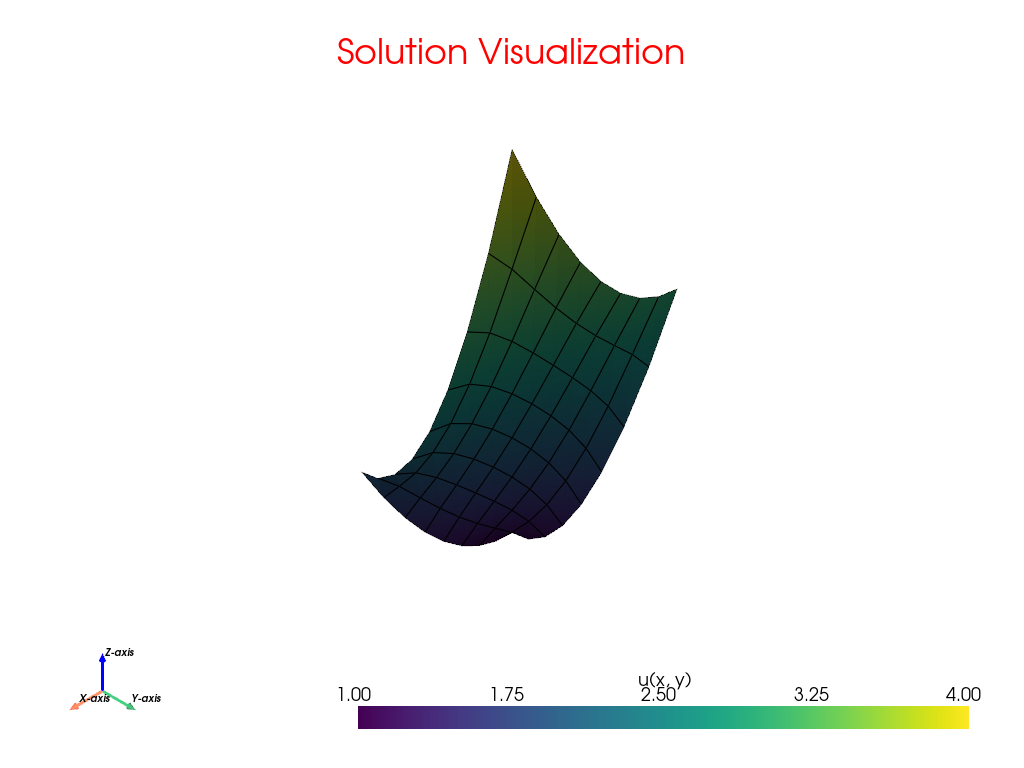

In [11]:
warped = sol_grid.warp_by_scalar()  # For 3D plots
sol_plotter2 = pv.Plotter()
sol_plotter2.add_mesh(warped, show_edges = True, show_scalar_bar = True, cmap = "viridis")
sol_plotter2.add_axes(line_width = 3, color = "black", xlabel = "X-axis", ylabel = "Y-axis", zlabel = "Z-axis") # Adding the default axes OXYZ
sol_plotter2.set_background("white") # Background color
sol_plotter2.view_isometric() # Setting a isometric view
sol_plotter2.add_title("Solution Visualization", font_size = 14, color = "red") # Title
sol_plotter2.show()